# Abstract:
The project utilizes machine learning techniques to predict flight fares. The dataset was thoroughly analyzed and visualized to understand the impact of factors such as airlines, departure times, and stops on flight prices. Regression models were trained and evaluated based on R² scores and mean absolute errors to ensure accuracy.

# Introduction:
The aviation industry is known for its dynamic pricing strategies that change based on various factors such as demand, fuel prices, seasonality, and competition. Accurately forecasting flight prices can be incredibly valuable for both consumers and airlines alike. By leveraging machine learning models to predict flight fares using historical data, we can gain valuable insights into pricing trends and factors that impact costs.

This project aims to use machine learning to predict flight fares. By analyzing historical data, we can identify patterns and relationships that impact prices. Our objective is to develop a predictive model that can adapt to new data and forecast future trends accurately. This will help to make informed decisions and improve the consumer experience while supporting airlines in their pricing strategies.

The dataset includes several features such as airlines, source and destination cities, number of stops, and departure and arrival times. Through an extensive exploratory data analysis and feature engineering, we aim to uncover significant patterns and relationships that impact flight prices.

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flight-price-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1957837%2F3228623%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T202913Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3fd5048f0a52a3ee05a52c2f37145dc4f09769d8734204f5cc4376b3a163fd47987df1f7a3342e46582bc123bdf9e6efdc4afc3e9853d3ec80e7411f73edfc661d2af181c12209b6a49f1e8f2c9f43a39fa314d8b5c92071b00f22830d337b46eaf2bf9103ee5f681701bf885dfc4340eae61e3af884d34ccc5f9d8c845169e2ae0ea5c9f23391951cef4a079f3407565eb034f28f5a7a21e8f01602cd105de956b89e267019202829f51cf732418f528a300beaa81750313b7f07e027b274a05c81e2eb39dea9599beaaf5ab0b06bc8b44a8b6986a1d8794319bfd4ffb2a514800de54fd9f0828a10a182918865395ca9fa39b8da9c6dd0df54f43159b663c9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4360218 bytes downloaded
Downloaded and uncompressed: flight-price-prediction
Data source import complete.


In [ ]:
# Importing the required libraries
import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flight-price-prediction/Clean_Dataset.csv
/kaggle/input/flight-price-prediction/business.csv
/kaggle/input/flight-price-prediction/economy.csv


In [ ]:
#imports

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV,KFold, cross_val_predict

from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, OrdinalEncoder

from sklearn.feature_extraction import DictVectorizer



%matplotlib inline

In [ ]:
# Fetching the data
df_main = pd.read_csv("/kaggle/input/flight-price-prediction/Clean_Dataset.csv")

In [ ]:
df_main

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


# EDA on the dataset



In [ ]:
df_main.shape

(300153, 12)

In [ ]:
df_main.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
df_main.shape

(300153, 11)

In [ ]:
df_main

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [ ]:
df_main.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

As there's no null values in the dataset, we can proceed to feature engineering etc

# Visualizations



In [ ]:
# Checking for the category columns and numerical columns

df_main.dtypes

airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

In [ ]:
category_cols = ['airline',  'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

<Axes: xlabel='destination_city'>

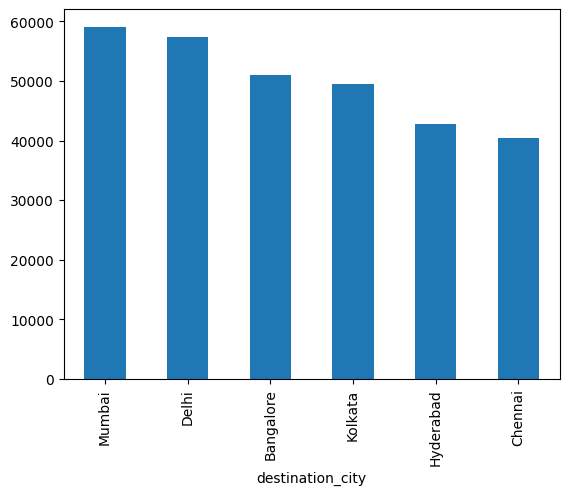

In [ ]:
# Let's see the most hot destination cities

df_main.destination_city.value_counts().plot.bar()


# Prices of Destination cities mapped to avg Prices



<Axes: xlabel='destination_city'>

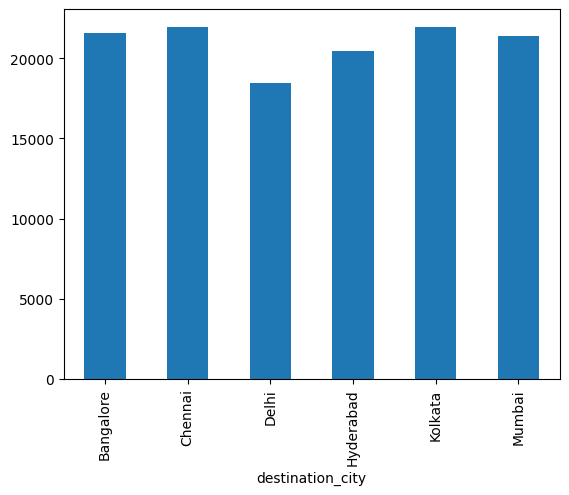

In [ ]:
df_main.groupby("destination_city")['price'].mean().plot.bar()

<Axes: xlabel='source_city'>

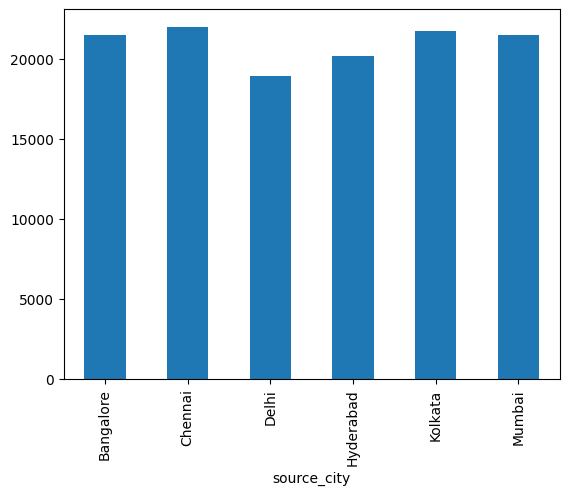

In [ ]:
df_main.groupby("source_city")['price'].mean().plot.bar()


<Axes: xlabel='airline'>

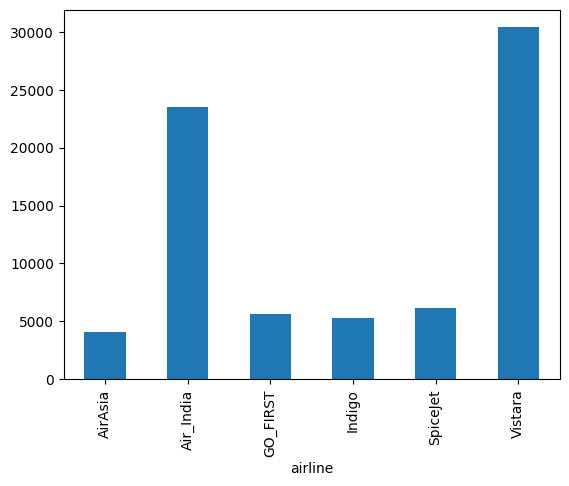

In [ ]:
df_main.groupby("airline")['price'].mean().plot.bar()

<Axes: xlabel='airline'>

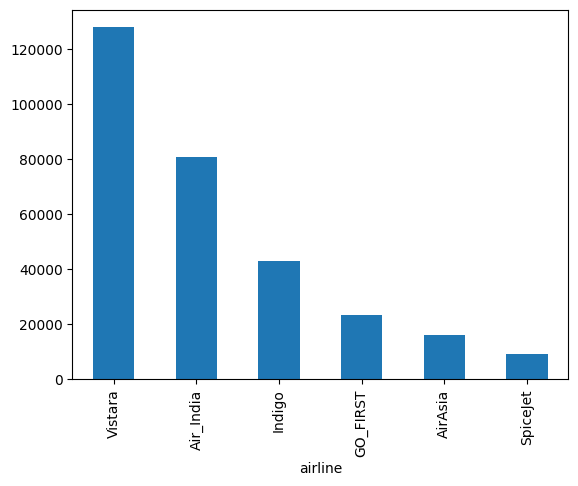

In [ ]:
df_main.airline.value_counts().plot.bar()

<Axes: xlabel='stops'>

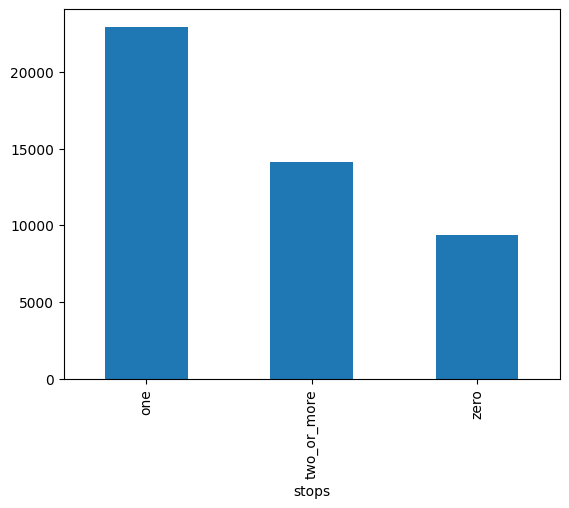

In [ ]:
df_main.groupby("stops")['price'].mean().plot.bar()

The ensemble of bar charts provides a multifaceted view of factors affecting flight prices. Mumbai and Delhi emerge as the most frequent destinations, reflecting their status as bustling travel hubs, yet this popularity doesn't directly translate into higher average prices when compared to other cities
The average fare varies more significantly with the airline, as evident from the sharp price peaks associated with certain carriers, underlining the premium placed on specific airline services. Additionally, flights with one stop are on average costlier than non-stop flights, hinting at the premium for direct routes. Overall, these visualizations underscore the intricate dynamics of flight pricing, shaped by a combination of destination popularity, airline brand, and the number of stops.

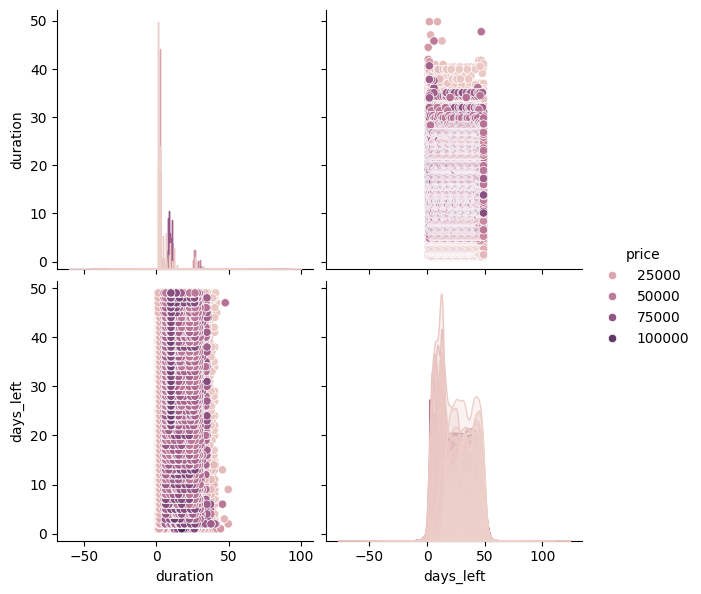

In [ ]:
sns.pairplot(df_main, hue = "price", height = 3)

*This visualization presents a pairplot of flight duration and days left before departure against flight prices, highlighted by color coding for different price levels. The duration shows a concentration of shorter flights across various price points, while days left exhibits a clustering of bookings made closer to the departure date, predominantly at lower prices. The data suggests a majority of the flights are of shorter duration and that booking flights closer to the departure date could be associated with lower prices.*

<Axes: xlabel='days_left'>

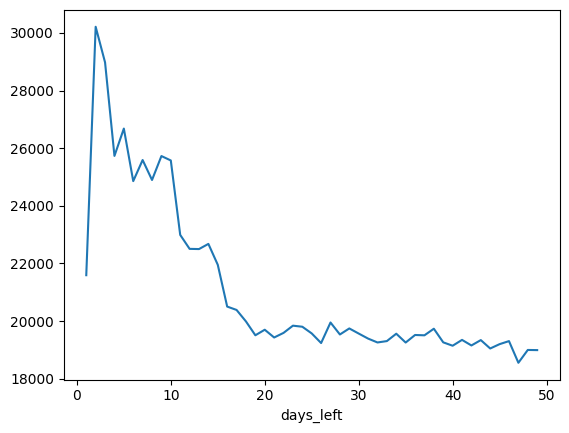

In [ ]:
df_main.groupby("days_left")['price'].mean().plot()

Flight prices tend to decline as the departure date gets closer, with a pronounced dip in fares for last-minute bookings.

<Axes: xlabel='departure_time'>

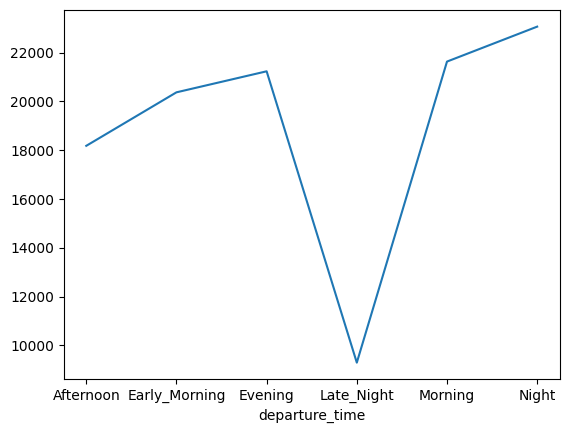

In [ ]:
df_main.groupby("departure_time")['price'].mean().plot()

Departure time influences ticket costs, with late-night flights typically being cheaper than those departing in the early morning or afternoon.

<Axes: xlabel='arrival_time'>

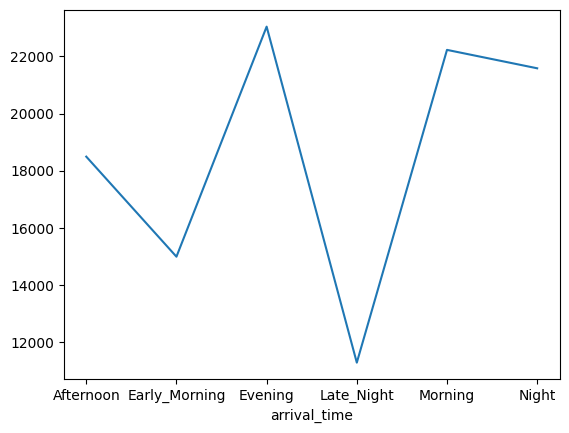

In [ ]:
df_main.groupby("arrival_time")['price'].mean().plot()

Arrival time is also a price determinant, with early morning landings generally commanding premium prices, likely due to their convenience.

<Axes: xlabel='class', ylabel='price'>

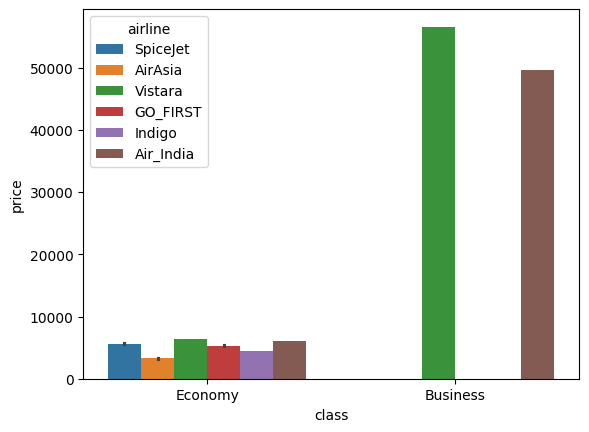

In [ ]:
sns.barplot(x = "class", y ="price",  data = df_main, estimator = np.median, hue = "airline")

The chart shows business class tickets are significantly pricier than economy across airlines, with Vistara and Air India having the highest business class fares.

<Axes: ylabel='Frequency'>

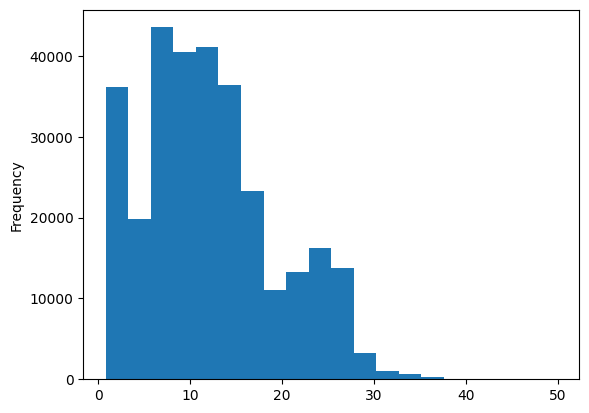

In [ ]:
df_main.duration.plot.hist(bins = 20)

The histogram displays the frequency of flights across different durations, with the majority concentrated in shorter flights, peaking under 10 hours. There is a noticeable decline in frequency as flight duration increases, indicating that longer flights are less common. The distribution suggests a preference or higher availability for shorter domestic or regional flights.

In [ ]:
df_main[['airline_code', 'flight_number']] = df_main['flight'].str.split('-', n=1, expand=True)
df_main.drop("flight", axis = 1, inplace = True)
df_main.drop("airline_code", axis = 1, inplace = True)

In [ ]:
df_main['flight_number'] = df_main['flight_number'].astype('int')

In [ ]:
df_main.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,flight_number
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,8709
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,8157
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,764
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,995
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,963


In [ ]:
df_main.flight_number.value_counts()

flight_number
808     3313
706     3235
772     2860
774     2808
720     2650
        ... 
8480       1
405        1
3211       1
9974       1
1058       1
Name: count, Length: 1254, dtype: int64

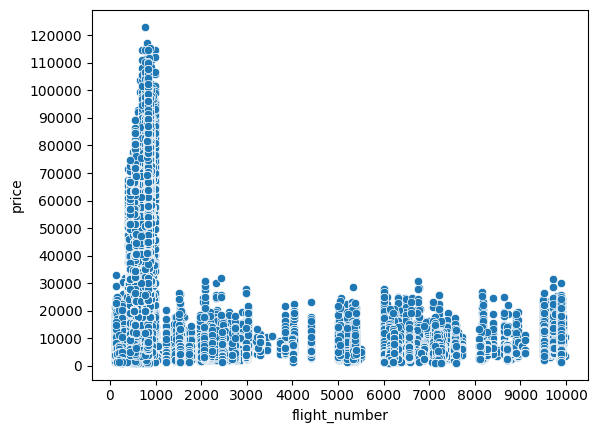

In [ ]:

sns.scatterplot(x = "flight_number", y = "price", data = df_main)
plt.xticks(range(0,10001,1000))
plt.yticks(range(0,120001,10000))
plt.show()

The scatter plot demonstrates the distribution of flight prices in relation to their assigned flight numbers. It reveals a dense cluster of higher-priced flights within the lower flight number range. The overall pattern does not suggest a direct or consistent correlation between the flight number and its price, indicating that flight numbers are not a reliable indicator for predicting fare prices.

# Converting Categorical Columns to Numerical Columns for Linear Regression


In [ ]:
le = LabelEncoder()

In [ ]:
df_main['stops'] = df_main['stops'].replace({'one': 1,
                                   'zero': 0,
                                   'two_or_more': 2})

In [ ]:
df_main[category_cols] = df_main[category_cols].apply(le.fit_transform)

In [ ]:
label_encoders = []
for column in category_cols:
    label_encoder = LabelEncoder()
    label_encoder.fit(df_main[column])
    label_encoders.append(label_encoder)
np.save("label_encoders.npy", label_encoders)

In [ ]:
df_main.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,flight_number
0,4,2,2,0,5,5,1,2.17,1,5953,8709
1,4,2,1,0,4,5,1,2.33,1,5953,8157
2,0,2,1,0,1,5,1,2.17,1,5956,764
3,5,2,4,0,0,5,1,2.25,1,5955,995
4,5,2,4,0,4,5,1,2.33,1,5955,963


In [ ]:
import joblib
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
label_encoding_mappings = {}

for column in category_cols:
    label_encoding_mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
label_encoding_mappings

{'airline': {'Business': 0, 'Economy': 1},
 'source_city': {'Business': 0, 'Economy': 1},
 'departure_time': {'Business': 0, 'Economy': 1},
 'stops': {'Business': 0, 'Economy': 1},
 'arrival_time': {'Business': 0, 'Economy': 1},
 'destination_city': {'Business': 0, 'Economy': 1},
 'class': {'Business': 0, 'Economy': 1}}

In [ ]:
df_main.to_csv("final_ds.csv")

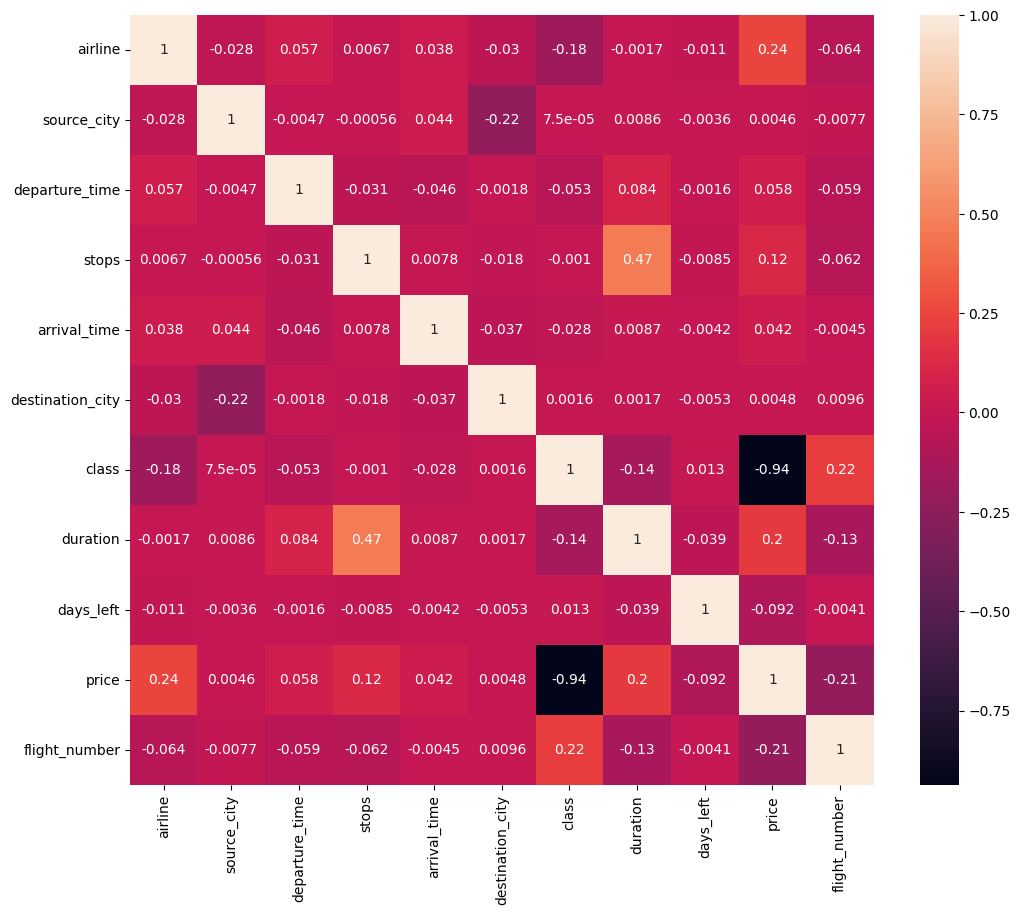

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase the size of the heatmap
plt.figure(figsize=(12, 10))

# Plot the heatmap with correlation values annotated
sns.heatmap(df_main.corr(), annot=True)

# Show the plot
plt.show()


The heatmap illustrates that class has a strong negative correlation with price, suggesting higher ticket classes are generally more expensive. Duration shows a positive correlation with stops, indicating that flights with longer durations are likely to have more stops. Meanwhile, the flight number has a negligible correlation with price, indicating that an airline's internal flight numbering system has little to no impact on fare pricing.

# Feature Engineering


In [ ]:
x = df_main.drop('price', axis = 1)
y = df_main['price']

# Training and Testing split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

# Using KFold CV


Using K-fold Cross Validation to assess how the model performs when it sees the unseen data that it hasn't been trained specifically on.

In [ ]:
kf = KFold(shuffle=True, random_state=42, n_splits=5)

**We've created a KFold object that will split our data into 5 folds while shuffling the data for randomness and setting a seed for reproducibility. **

In [ ]:
s = StandardScaler()
lr = LinearRegression()

In [ ]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

We created a pipeline object that combines data preprocessing and model fitting into a single step. Here, data is scaled by a scaler object (e.g., StandardScaler) and then fed into a linear regression model for training. Pipelines improve code readability, simplify data flow, and enable reusability.

In [ ]:
predictions = cross_val_predict(estimator, x, y, cv=kf)

Here, we utilized k-fold cross-validation to generate predictions for my data using the pipeline "estimator"

1. The cross_val_predict function performs the following steps for each fold:

Separates a fold for testing and uses the remaining folds for training the pipeline (estimator).
Once the pipeline is trained on the training data, it's used to predict the labels (or values) for the data points in the testing fold.

2. Predictions made on each fold's testing data. After iterating through all folds, cross_val_predict combines all the individual predictions from each fold into a single array (predictions).

In [ ]:
r2_score(y, predictions)

0.9063636882936632

The R-squared score is 0.90636. This indicates that approximately 90.6% of the variation in the actual values (y) is captured by the predictions (predictions) made by our model.

In [ ]:
mean_absolute_error(y,predictions)

4545.996044591107

MAE of 4545.996 suggests that the model's predictions deviate from the actual values by an average of around 4545.996 on the units of your target variable.

# Hyperparameter Tuning


In [ ]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

We created a numpy array called alphas.

1e-9: This is the starting point of the geometric space,
1e0: This is the ending point of the geometric space,
num=10: This specifies the number of elements to generate in the geometric space. Here, it will create 10 values.


In [ ]:
las = Lasso()

In [ ]:
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, x, y, cv = kf)

    score = r2_score(y, predictions)

    scores.append(score)

Here we're trying to fit Lasso regression models with different alpha values (regularization parameter).
Uses K-fold cross-validation to evaluate the performance of each model on unseen data.
Stores the R-squared score, a measure of model fit, for each alpha value.

In [ ]:
list(zip(alphas,scores))

[(1e-09, 0.9063636882936632),
 (1e-08, 0.9063636882936632),
 (1e-07, 0.906363688293663),
 (1e-06, 0.9063636882936594),
 (1e-05, 0.9063636882936199),
 (0.0001, 0.9063636882933672),
 (0.001, 0.9063636882903774),
 (0.01, 0.9063636882403515),
 (0.1, 0.9063636878222452),
 (1.0, 0.9063636674357426)]

Here, we are creating a list of values which zip function has created as a sequence-like object


In [ ]:
Lasso(alpha=1e-6).fit(x, y).coef_

array([ 9.56567751e+02,  1.12733502e+02,  8.91226224e+01,  6.11007662e+03,
        1.66349607e+02,  1.62211911e+02, -4.50616969e+04,  7.28046323e+01,
       -1.29128693e+02,  1.84544036e-02])

Defines a Lasso regression model with a specific alpha value (regularization parameter).
Trains the model on your data (x and y).
Retrieves the coefficients learned by the model for each feature in your data.

A positive coefficient indicates a positive relationship between the feature and the target variable, while a negative coefficient suggests a negative relationship. The magnitude of the coefficient reflects the strength of the relationship.

**Alphas are defined on a logarithmic scale from 1e-9 to 1, and for each alpha, a Lasso regression model is created and cross-validated.**

In [ ]:
Lasso(alpha=1.0).fit(x, y).coef_

array([ 9.56514668e+02,  1.12298807e+02,  8.86899314e+01,  6.10144221e+03,
        1.66047091e+02,  1.61736464e+02, -4.50563837e+04,  7.30570188e+01,
       -1.29123568e+02,  1.81722432e-02])

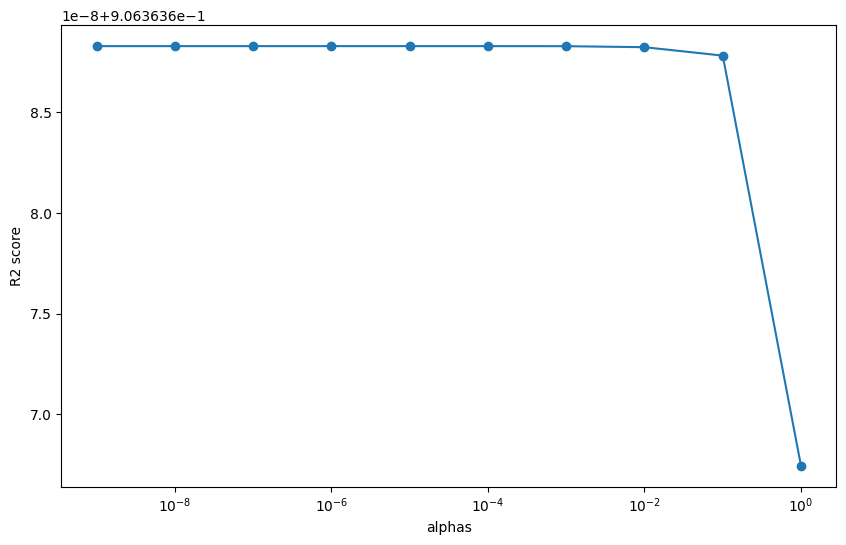

In [ ]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('alphas')
plt.ylabel('R2 score');

*The plot shows that the R² score for the model is stable across a range of small alpha values, indicating a minimal impact from regularization. A sharp decline in R² score at an alpha of 1 suggests that excessive regularization diminishes model performance. Optimal alpha values for this model are likely between 1e-8 and 1e-2, where the R² score is maximized, balancing model complexity and fit.*

In [ ]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(x, y)
best_estimator.score(x, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.208e+11, tolerance: 1.546e+10
  model = cd_fast.enet_coordinate_descent(


0.9401489791705203

Creates a pipeline that combines data scaling, polynomial feature creation, and Lasso regression with regularization.
Fits the entire pipeline to the training data.
Evaluates the performance of the pipeline on the same data using R-squared (or another scoring metric).

In [ ]:
predii = cross_val_predict(best_estimator, x, y, cv=kf)
r2_score(y, predii)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e+11, tolerance: 1.237e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e+11, tolerance: 1.236e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e+11, tolerance: 1.237e

0.9401181954663129

 **Model Fitting and Evaluation:**

The above constructs a machine learning pipeline with a StandardScaler for feature scaling, PolynomialFeatures to create polynomial interactions between features, and a Lasso regression model with an alpha value of 0.03 to penalize the complexity of the model.

The best_estimator is fit to the data x and y, and achieves an R² score of approximately 0.9401.

In [ ]:
# Same estimator as before

estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [ ]:
grid.fit(x,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [ ]:
y_predict = grid.predict(x)

In [ ]:
r2_score(y, y_predict)

0.9485521365059661

The model yields an R² score of approximately 0.9401, indicating a strong fit to the data

In [ ]:
import joblib
joblib.dump(grid, "model_main_1.pkl")

['model_main_1.pkl']

In [ ]:
x.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,flight_number
0,4,2,2,0,5,5,1,2.17,1,8709
1,4,2,1,0,4,5,1,2.33,1,8157
2,0,2,1,0,1,5,1,2.17,1,764
3,5,2,4,0,0,5,1,2.25,1,995
4,5,2,4,0,4,5,1,2.33,1,963


In [ ]:
y.head()

0    5953
1    5953
2    5956
3    5955
4    5955
Name: price, dtype: int64

# Making Streamlit application

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


# Running Streamlit app using ngrok


In [ ]:
%%writefile app.py

import streamlit as st

st.write(' # Hello World')

Writing app.py


# Conclusion:

The predictive model has displayed a high level of accuracy in forecasting flight prices based on various features, with an R² score of around 0.95. This finding can assist consumers in predicting flight prices and making informed booking decisions. In the future, more complex models and additional features, such as seasonal trends or special events, could be explored to further boost prediction accuracy.

# References:


# License:
Created by Tejaswi Tallapally, Ram Prashanth, Lok Venkatesh.


*** References:***

https://www.analyticsvidhya.com/blog/2022/01/flight-fare-prediction-using-machine-learning/

https://github.com/KunalDhavale/Flight-Fare-Prediction

https://github.com/prakash100198/Flight-Fare-Prediction-Web-App

https://ieeexplore.ieee.org/abstract/document/8081365

https://ceur-ws.org/Vol-3283/Paper90.pdf







MIT License

Copyright (c) 2024 Tejaswitallapally.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.